**TRACCIA T8 - DI IORIO LUDOVICO - 0336019 - NOTEBOOK 1**

DEFINIZIONE DELLE LIBRERIE E DEI PARAMETRI


In [ ]:
# Caricamento delle librerie e dei moduli
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

# Montiamo Google Drive nel notebook Colab
from google.colab import drive

drive.mount("/content/drive")

PATH_DIR = "/content/drive/MyDrive/Colab Notebooks/102flowers"

# Definizione dei parametri
EPOCHS = 10 # Numero di epoche per l'addestramento

BATCH_SIZE = 100 # Numero di batch in cui suddividere il training set

# Dimensione delle immagini post-processamento
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Percentuale di immagini usate per il test set
TEST_PERCENTAGE = 0.10

Mounted at /content/drive


CARICAMENTO DEL DATASET, DIVISIONE IN TRAINING SET E TEST SET, E NORMALIZZAZIONE

In [ ]:
# Funzione di normalizzazione
def normalize(image):
    return tf.cast(image, tf.float32) / 255.0

In [ ]:
# Creazione del dataset
training_set, test_set = tf.keras.utils.image_dataset_from_directory(
    directory = PATH_DIR, # directory su google drive
    labels = None, # dataset senza etichette
    batch_size = BATCH_SIZE, # dimenensioni dei batch
    image_size = (IMG_HEIGHT, IMG_WIDTH), # dimensioni dell'immagine
    shuffle = True, # le immagini vengono casualmente mescolate
    seed = 10, # seme per mescolare le immagini
    validation_split = TEST_PERCENTAGE, # percentuale di immagini riservate al test set
    subset = "both" # per restituire sia train che test set
)

#Normalizzazione dei due set
training_set = training_set.map(lambda x: (normalize(x), normalize(x)))
test_set = test_set.map(lambda x: (normalize(x), normalize(x)))

Found 8201 files.
Using 7381 files for training.
Using 820 files for validation.


Estrapolazione del validation set dal training set

In [ ]:
dim = tf.cast(tf.cast(training_set.cardinality(), tf.float64)*0.1, tf.int64)
val_set = training_set.take(dim) # estrazione del validation set
training_set = training_set.skip(dim) # rimozione del validation set dal training set

In [ ]:
#convertiamo test_set in un array numpy
test_data = []

for img, _ in test_set.take(len(test_set)):
  test_data.append(img.numpy())

test_data = np.concatenate(test_data, axis = 0)

STRUTTURA DELL' AUTOENCODER

In [ ]:
class Autoencoder(keras.models.Model):
  def __init__(self, latent_shape):
    super(Autoencoder, self).__init__()

    self.latent_dim = latent_shape[0]*latent_shape[1] # numero di unità del livello completamente connesso (pixel dell'immagine compressa)

    self.encoder = tf.keras.Sequential([                                                                                                                                  #(256x256)x3
      tf.keras.layers.Conv2D(8, 3, strides = 2, activation='relu', padding='same'), # livello convoluzionale (dimensione dimezzata)                                       #(128x128)x8
      tf.keras.layers.MaxPooling2D((2, 2), padding='same'), # riduzione della dimensione con max pooling (dimensione dimezzata)                                           #(64x64)x8
      tf.keras.layers.Conv2D(16, 3, strides = 2, activation='relu', padding='same'), # livello convoluzionale (dimensione dimezzata)                                      #(32x32)x16
      tf.keras.layers.MaxPooling2D((2, 2), padding='same'), # riduzione della dimensione con max pooling (dimensione dimezzata)                                           #(16x16)x16
      tf.keras.layers.Flatten(),                                                                                                                                          #(16x16x16)x1
      tf.keras.layers.Dense(self.latent_dim, activation='relu'), # livello completamente connesso                                                                         #(latent_shape)
    ])

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(16*16*16, activation='relu', input_shape=(self.latent_dim,)), # livello completamente connesso                                                #(16x16x16)x1
      tf.keras.layers.Reshape((16,16,16)), # ri-dimensioniamo                                                                                                             #(16x16)x16
      tf.keras.layers.UpSampling2D((2,2), interpolation='bilinear'), # aumento della dimensione con max unpooling (dimensione raddoppiata)                                #(32x32)x16
      tf.keras.layers.Conv2DTranspose(8, 3, strides = 2, activation='relu', padding='same'), # livello convoluzionale (dimensione raddoppiata)                            #(64x64)x8
      tf.keras.layers.UpSampling2D((2,2), interpolation='bilinear'), # aumento della dimensione con max unpooling (dimensione raddoppiata)                                #(128x128)x8
      tf.keras.layers.Conv2DTranspose(3, 3, strides = 2, activation='relu', padding='same') # livello convoluzionale con 3 canali in uscita (dimensione raddoppiata)      #(296x296)x3
    ])

  def call(self, x):
    encoded = self.encoder(x) # x: dimensione dello spazio latente
    decoded = self.decoder(encoded) # decoded: immagine ricostruita
    return decoded

ADDESTRAMENTO 8x8

In [ ]:
latent_shape = (8, 8) # dimensione dello spazio latente
autoencoder = Autoencoder(latent_shape) # istaziazione del modello

autoencoder.compile(optimizer='adam', loss='mean_absolute_error') # configurazione per l'addestramento del modello

autoencoder.fit(training_set, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_set, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - loss: 0.2788 - val_loss: 0.1794
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - loss: 0.1747 - val_loss: 0.1577
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - loss: 0.1573 - val_loss: 0.1488
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - loss: 0.1468 - val_loss: 0.1394
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - loss: 0.1396 - val_loss: 0.1356
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - loss: 0.1356 - val_loss: 0.1330
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - loss: 0.1313 - val_loss: 0.1278
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - loss: 0.1262 - val_loss: 0.1204
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - loss: 0.1227 - val_loss: 0.1194
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - loss: 0.1195 - val_loss: 0.1174


INFERENCE TIME 8x8

In [ ]:
def show_results(test_data, encoded_imgs, decoded_imgs):
  n = 10
  plt.figure(figsize=(20, 6))
  for i in range(n):
    # immagine originale
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(test_data[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # immagine compressa
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(latent_shape))
    plt.title("latent")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # immagine ricostruita
    ax = plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()


In [ ]:
# Generazione delle immagini compresse
encoded_imgs = autoencoder.encoder.predict(test_data)

# Ricostruzione delle immagini
decoded_imgs = autoencoder.decoder.predict(encoded_imgs)

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step


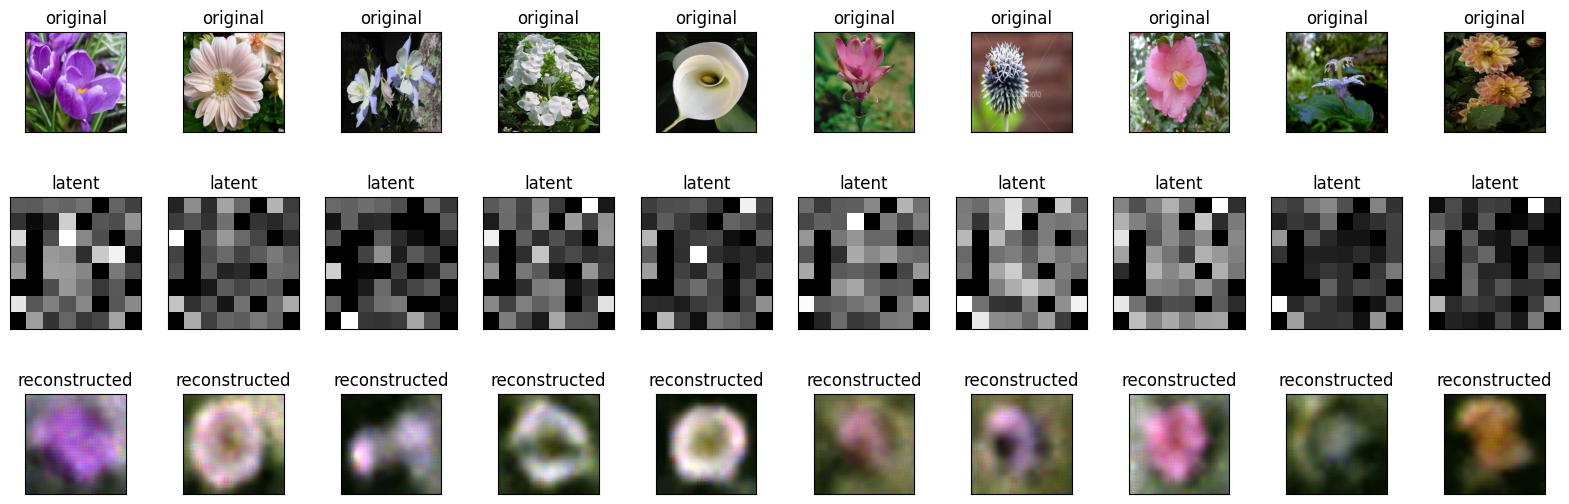

In [ ]:
# Visualizzazione di 10 immagini
i = 1
show_results(test_data[i:i+10], encoded_imgs[i:i+10], decoded_imgs[i:i+10])

SALVATAGGIO DEI PESI DEL MODELLO 8x8

In [ ]:
!pip install pyyaml h5py

import os

In [ ]:
checkpoint_path = os.getcwd() + "/drive/MyDrive/Colab Notebooks/training/cp-(8,8).weights.h5"

autoencoder.save_weights(checkpoint_path)

VALUTAZIONE DELLE RICOSTRUZIONE 8x8

In [ ]:
from tensorflow import image

# Funzione che la ricostruzione delle immagini usando la metrica SSIM
def evaluate(img1, img2):
  ret = image.ssim(img1, img2, max_val=1.0)
  ssim_mean = tf.reduce_mean(ret)
  ssim_variance = tf.math.reduce_variance(ret)

  return ssim_mean, ssim_variance

In [ ]:
ssim_mean, ssim_variance = evaluate(test_data, decoded_imgs)

print("SSIM medio: ", ssim_mean.numpy())
print("SSIM varianza: ", ssim_variance.numpy())

SSIM medio:  0.34503788
SSIM varianza:  0.011947781




---


ADDESTRAMENTO 10x10

In [ ]:
latent_shape = (10, 10) # dimensione dello spazio latente
autoencoder = Autoencoder(latent_shape) # istaziazione del modello

autoencoder.compile(optimizer='adam', loss='mean_absolute_error') # configurazione per l'addestramento del modello

autoencoder.fit(training_set, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_set, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - loss: 0.3049 - val_loss: 0.2018
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - loss: 0.1866 - val_loss: 0.1663
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - loss: 0.1638 - val_loss: 0.1556
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - loss: 0.1548 - val_loss: 0.1492
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - loss: 0.1486 - val_loss: 0.1442
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - loss: 0.1437 - val_loss: 0.1372
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - loss: 0.1365 - val_loss: 0.1309
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - loss: 0.1295 - val_loss: 0.1251
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - loss: 0.1251 - val_loss: 0.1204
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - loss: 0.1217 - val_loss: 0.1203


INFERENCE TIME 10x10

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step


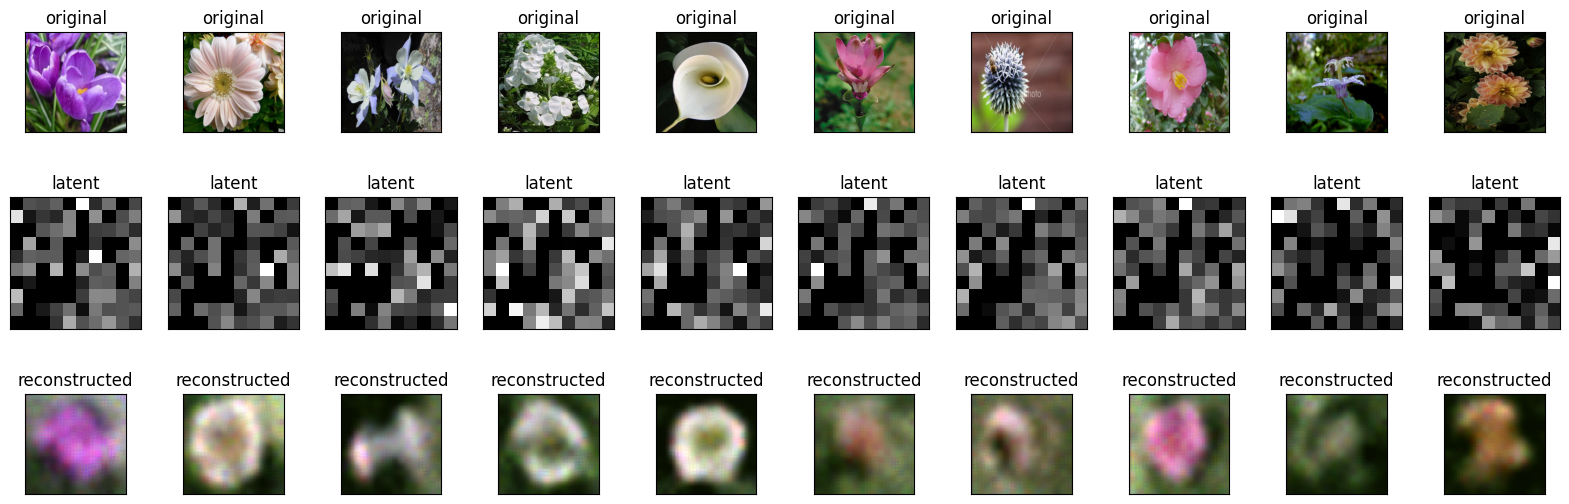

In [ ]:
# Generazione delle immagini compresse
encoded_imgs = autoencoder.encoder.predict(test_data)

# Ricostruzione delle immagini
decoded_imgs = autoencoder.decoder.predict(encoded_imgs)

# Visualizzazione di 10 immagini
i = 1
show_results(test_data[i:i+10], encoded_imgs[i:i+10], decoded_imgs[i:i+10])

SALVATAGGIO DEI PESI DEL MODELLO 10x10

In [ ]:
checkpoint_path = os.getcwd() + "/drive/MyDrive/Colab Notebooks/training/cp-(10,10).weights.h5"

autoencoder.save_weights(checkpoint_path)

VALUTAZIONE DELLE RICOSTRUZIONE 10x10

In [ ]:
ssim_mean, ssim_variance = evaluate(test_data, decoded_imgs)

print("SSIM medio: ", ssim_mean.numpy())
print("SSIM varianza: ", ssim_variance.numpy())

SSIM medio:  0.3397185
SSIM varianza:  0.011339658




---


ADDESTRAMENTO 12x12

In [ ]:
latent_shape = (12, 12) # dimensione dello spazio latente
autoencoder = Autoencoder(latent_shape) # istaziazione del modello

autoencoder.compile(optimizer='adam', loss='mean_absolute_error') # configurazione per l'addestramento del modello

autoencoder.fit(training_set, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_set, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - loss: 0.3026 - val_loss: 0.1975
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - loss: 0.1935 - val_loss: 0.1654
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - loss: 0.1602 - val_loss: 0.1485
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - loss: 0.1472 - val_loss: 0.1386
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - loss: 0.1368 - val_loss: 0.1335
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - loss: 0.1312 - val_loss: 0.1280
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - loss: 0.1276 - val_loss: 0.1244
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - loss: 0.1244 - val_loss: 0.1203
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - loss: 0.1206 - val_loss: 0.1190
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - loss: 0.1176 - val_loss: 0.1158


INFERENCE TIME 12x12

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step


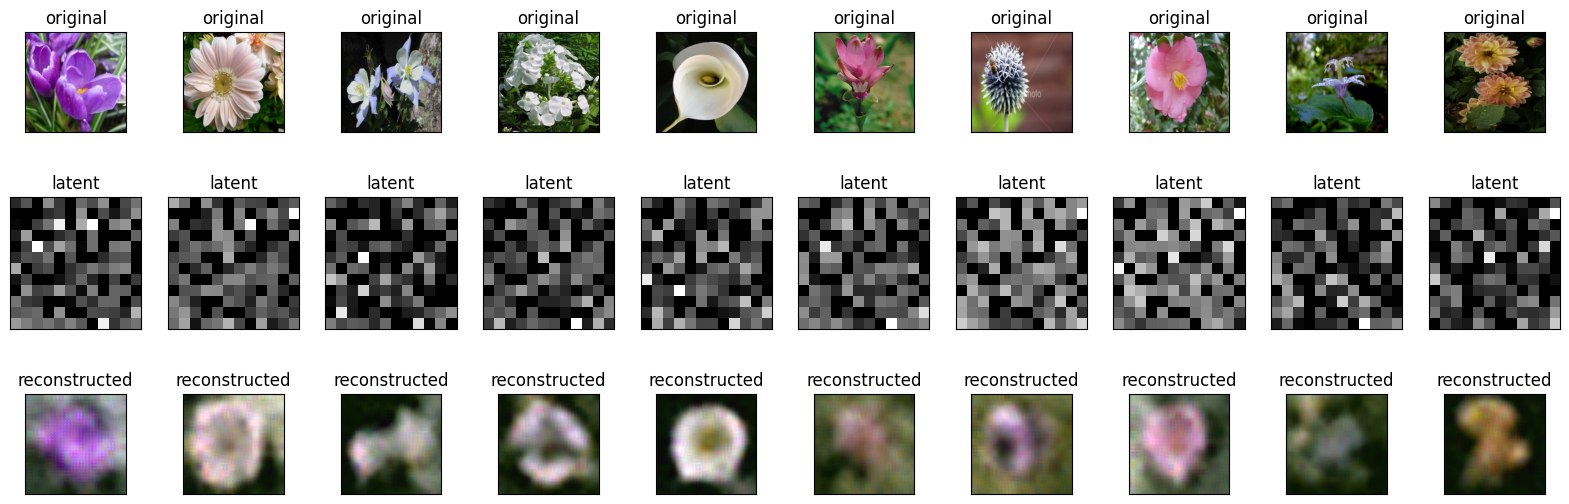

In [ ]:
# Generazione delle immagini compresse
encoded_imgs = autoencoder.encoder.predict(test_data)

# Ricostruzione delle immagini
decoded_imgs = autoencoder.decoder.predict(encoded_imgs)

# Visualizzazione di 10 immagini
i = 1
show_results(test_data[i:i+10], encoded_imgs[i:i+10], decoded_imgs[i:i+10])

SALVATAGGIO DEI PESI DEL MODELLO 12x12

In [ ]:
checkpoint_path = os.getcwd() + "/drive/MyDrive/Colab Notebooks/training/cp-(12,12).weights.h5"

autoencoder.save_weights(checkpoint_path)

VALUTAZIONE DELLE RICOSTRUZIONE 12x12

In [ ]:
ssim_mean, ssim_variance = evaluate(test_data, decoded_imgs)

print("SSIM medio: ", ssim_mean.numpy())
print("SSIM varianza: ", ssim_variance.numpy())

SSIM medio:  0.33539808
SSIM varianza:  0.011714595




---


ADDESTRAMENTO 16x16

In [ ]:
latent_shape = (16, 16) # dimensione dello spazio latente
autoencoder = Autoencoder(latent_shape) # istaziazione del modello

autoencoder.compile(optimizer='adam', loss='mean_absolute_error') # configurazione per l'addestramento del modello

autoencoder.fit(training_set, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_set, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - loss: 0.2750 - val_loss: 0.1768
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - loss: 0.1657 - val_loss: 0.1451
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - loss: 0.1432 - val_loss: 0.1351
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - loss: 0.1346 - val_loss: 0.1293
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - loss: 0.1289 - val_loss: 0.1272
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - loss: 0.1247 - val_loss: 0.1216
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - loss: 0.1214 - val_loss: 0.1185
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - loss: 0.1190 - val_loss: 0.1163
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - loss: 0.1163 - val_loss: 0.1128
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - loss: 0.1125 - val_loss: 0.1086


INFERENCE TIME 16x16

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step


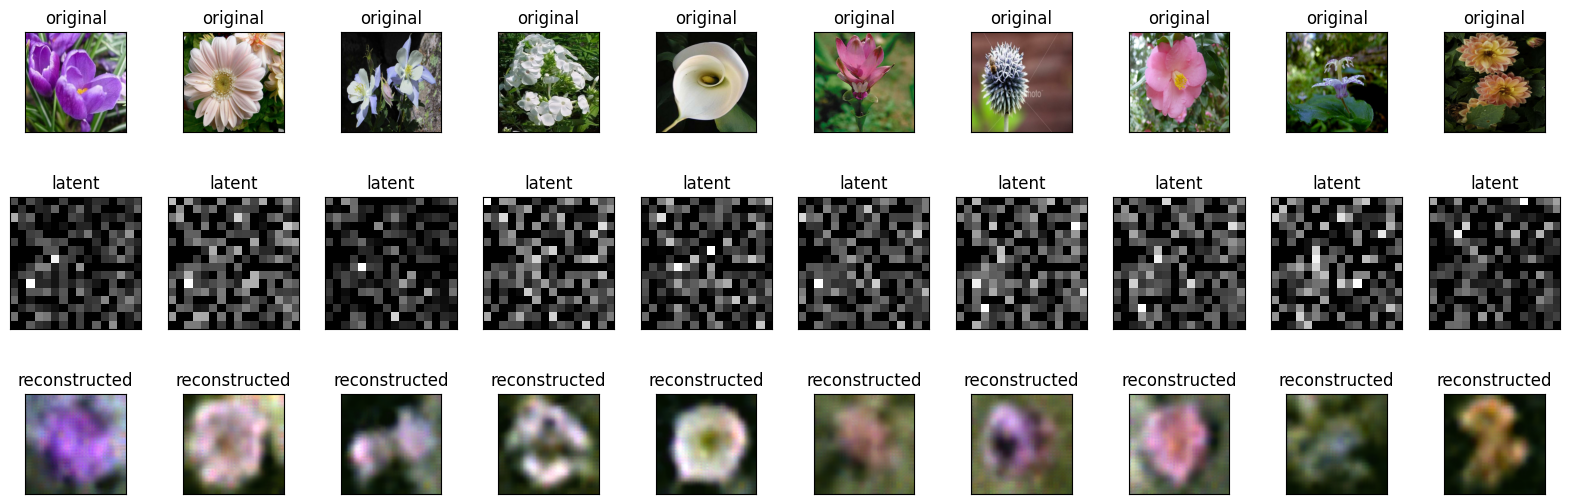

In [ ]:
# Generazione delle immagini compresse
encoded_imgs = autoencoder.encoder.predict(test_data)

# Ricostruzione delle immagini
decoded_imgs = autoencoder.decoder.predict(encoded_imgs)

# Visualizzazione di 10 immagini
i = 1
show_results(test_data[i:i+10], encoded_imgs[i:i+10], decoded_imgs[i:i+10])

SALVATAGGIO DEI PESI DEL MODELLO 16x16

In [ ]:
checkpoint_path = os.getcwd() + "/drive/MyDrive/Colab Notebooks/training/cp-(16,16).weights.h5"

autoencoder.save_weights(checkpoint_path)

VALUTAZIONE DELLE RICOSTRUZIONE 16x16

In [ ]:
ssim_mean, ssim_variance = evaluate(test_data, decoded_imgs)

print("SSIM medio: ", ssim_mean.numpy())
print("SSIM varianza: ", ssim_variance.numpy())

SSIM medio:  0.35113034
SSIM varianza:  0.012324707




---


ADDESTRAMENTO 24x24

In [ ]:
latent_shape = (24, 24) # dimensione dello spazio latente
autoencoder = Autoencoder(latent_shape) # istaziazione del modello

autoencoder.compile(optimizer='adam', loss='mean_absolute_error') # configurazione per l'addestramento del modello

autoencoder.fit(training_set, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_set, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - loss: 0.2913 - val_loss: 0.1787
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - loss: 0.1679 - val_loss: 0.1487
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - loss: 0.1468 - val_loss: 0.1361
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - loss: 0.1361 - val_loss: 0.1311
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - loss: 0.1291 - val_loss: 0.1245
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - loss: 0.1241 - val_loss: 0.1204
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - loss: 0.1200 - val_loss: 0.1170
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - loss: 0.1163 - val_loss: 0.1134
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - loss: 0.1122 - val_loss: 0.1103
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - loss: 0.1084 - val_loss: 0.1059


INFERENCE TIME 24x24

In [ ]:
# Generazione delle immagini compresse
encoded_imgs = autoencoder.encoder.predict(test_data)

# Ricostruzione delle immagini
decoded_imgs = autoencoder.decoder.predict(encoded_imgs)

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step


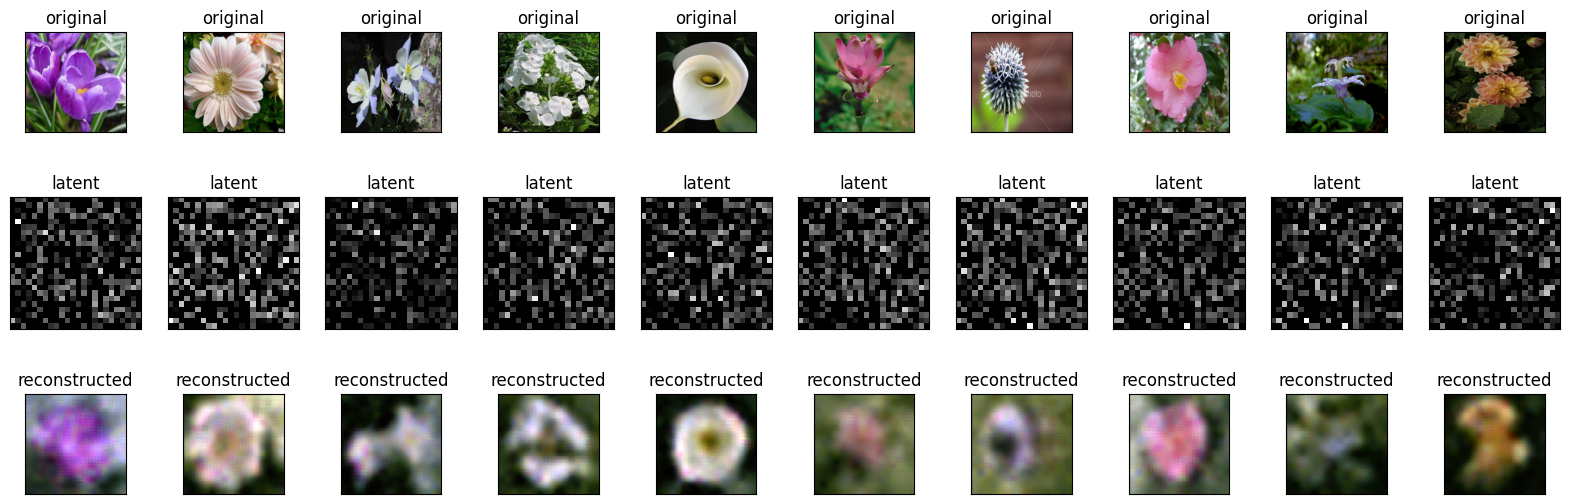

In [ ]:
# Visualizzazione di 10 immagini
i = 1
show_results(test_data[i:i+10], encoded_imgs[i:i+10], decoded_imgs[i:i+10])

SALVATAGGIO DEI PESI DEL MODELLO 24x24x

In [ ]:
checkpoint_path = os.getcwd() + "/drive/MyDrive/Colab Notebooks/training/cp-(24,24).weights.h5"

autoencoder.save_weights(checkpoint_path)

VALUTAZIONE DELLE RICOSTRUZIONE 24x24x

In [ ]:
ssim_mean, ssim_variance = evaluate(test_data, decoded_imgs)

print("SSIM medio: ", ssim_mean.numpy())
print("SSIM varianza: ", ssim_variance.numpy())

SSIM medio:  0.3727954
SSIM varianza:  0.013403068




---


ADDESTRAMENTO 32x32

In [ ]:
latent_shape = (32, 32) # dimensione dello spazio latente
autoencoder = Autoencoder(latent_shape) # istaziazione del modello

autoencoder.compile(optimizer='adam', loss='mean_absolute_error') # configurazione per l'addestramento del modello

autoencoder.fit(training_set, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_set, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - loss: 0.2807 - val_loss: 0.1746
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - loss: 0.1678 - val_loss: 0.1497
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - loss: 0.1462 - val_loss: 0.1351
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - loss: 0.1329 - val_loss: 0.1250
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - loss: 0.1251 - val_loss: 0.1226
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - loss: 0.1214 - val_loss: 0.1141
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - loss: 0.1134 - val_loss: 0.1099
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - loss: 0.1104 - val_loss: 0.1058
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - loss: 0.1065 - val_loss: 0.1056
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - loss: 0.1041 - val_loss: 0.1035


INFERENCE TIME 32x32

In [ ]:
# Generazione delle immagini compresse
encoded_imgs = autoencoder.encoder.predict(test_data)

# Ricostruzione delle immagini
decoded_imgs = autoencoder.decoder.predict(encoded_imgs)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step


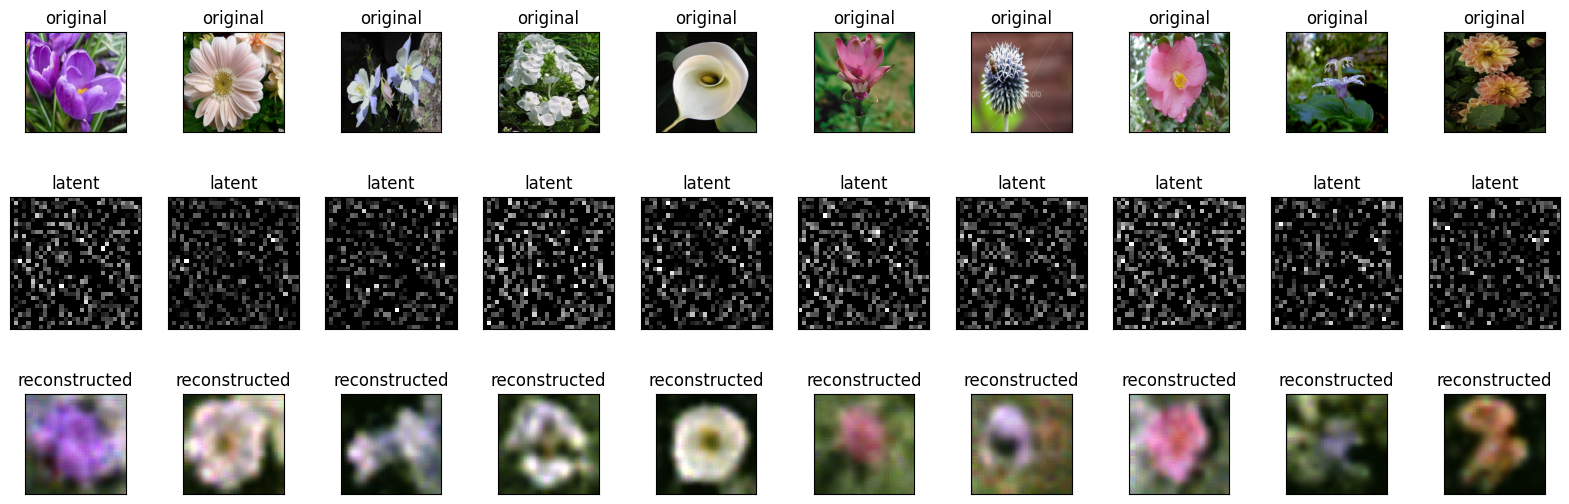

In [ ]:
# Visualizzazione di 10 immagini
i = 1
show_results(test_data[i:i+10], encoded_imgs[i:i+10], decoded_imgs[i:i+10])

SALVATAGGIO DEI PESI DEL MODELLO 32x32

In [ ]:
checkpoint_path = os.getcwd() + "/drive/MyDrive/Colab Notebooks/training/cp-(32,32).weights.h5"

autoencoder.save_weights(checkpoint_path)

VALUTAZIONE DELLE RICOSTRUZIONE 32x32

In [ ]:
ssim_mean, ssim_variance = evaluate(test_data, decoded_imgs)

print("SSIM medio: ", ssim_mean.numpy())
print("SSIM varianza: ", ssim_variance.numpy())

SSIM medio:  0.37024102
SSIM varianza:  0.012977039




---


---







**VARIANTE 1**: tecniche introdotte nel modello
*   Parameter initialization: He initialization
*   Regolarizzazione: L2 regularization
*   Data augmentation
*   Dropout



In [ ]:
from keras import regularizers

In [ ]:
class Autoencoder2(keras.models.Model):
  def __init__(self, latent_shape):
    super(Autoencoder2, self).__init__()

    self.latent_dim = latent_shape[0]*latent_shape[1] # numero di unità del livello completamente connesso (pixel dell'immagine compressa)

    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(8, 3, strides = 2, activation='relu', padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=regularizers.L2(0.01)), # livello convoluzionale (dimensione dimezzata)
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.MaxPooling2D((2, 2), padding='same'), # riduzione della dimensione con max pooling (dimensione dimezzata)
      tf.keras.layers.Conv2D(16, 3, strides = 2, activation='relu', padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=regularizers.L2(0.01)), # livello convoluzionale (dimensione dimezzata)
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.MaxPooling2D((2, 2), padding='same'), # riduzione della dimensione con max pooling (dimensione dimezzata)
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(self.latent_dim, activation='relu', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=regularizers.L2(0.01)), # livello completamente connesso

    ])

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(16*16*16, activation='relu', input_shape=(self.latent_dim,), kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=regularizers.L2(0.01)), # livello completamente connesso
      tf.keras.layers.Reshape((16,16,16)), # ri-dimensioniamo
      tf.keras.layers.UpSampling2D((2,2), interpolation='bilinear'), # aumento della dimensione con max unpooling (dimensione raddoppiata)
      tf.keras.layers.Conv2DTranspose(8, 3, strides = 2, activation='relu', padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=regularizers.L2(0.01)), # livello convoluzionale (dimensione raddoppiata)
      tf.keras.layers.UpSampling2D((2,2), interpolation='bilinear'), # aumento della dimensione con max unpooling (dimensione raddoppiata)
      tf.keras.layers.Conv2DTranspose(3, 3, strides = 2, activation='relu', padding='same', kernel_initializer=keras.initializers.HeNormal(), kernel_regularizer=regularizers.L2(0.01)) # livello convoluzionale con 3 canali in uscita (dimensione raddoppiata)
    ])

  def call(self, x):
    encoded = self.encoder(x) # x: dimensione dello spazio latente
    decoded = self.decoder(encoded) # decoded: immagine ricostruita
    return decoded

Data augmentation

In [ ]:
# livelli di pre-processamento
aug_transform = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), # cambia la posizione dei fiori
    tf.keras.layers.RandomRotation(0.1), # modifica la rotazione
    tf.keras.layers.RandomZoom(0.1), # aumenta lo zoom sul fiore
    tf.keras.layers.RandomContrast(0.1), # modifica il contrasto della luce
    tf.keras.layers.RandomTranslation(0.1, 0.1) # applica variazioni nella posizione del fiore
])

aug_set = training_set.map(lambda x, y: (aug_transform(x), aug_transform(y)))

In [ ]:
training_set = training_set.concatenate(aug_set)

Addestramento

In [ ]:
latent_shape = (16, 16) # dimensione dello spazio latente
autoencoder2 = Autoencoder2(latent_shape) # istaziazione del modello

autoencoder2.compile(optimizer='adam', loss='mean_absolute_error') # configurazione per l'addestramento del modello

autoencoder2 .fit(training_set, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_set, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 734s 5s/step - loss: 51.5194 - val_loss: 5.8846
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 670s 5s/step - loss: 3.5014 - val_loss: 0.5528
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 690s 5s/step - loss: 0.4286 - val_loss: 0.2695
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 672s 5s/step - loss: 0.2609 - val_loss: 0.2413
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 667s 5s/step - loss: 0.2388 - val_loss: 0.2308
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 658s 5s/step - loss: 0.2311 - val_loss: 0.2258
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 653s 5s/step - loss: 0.2283 - val_loss: 0.2268
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 667s 5s/step - loss: 0.2268 - val_loss: 0.2242
Epoch 9/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 676s 5s/step - loss: 0.2261 - val_loss: 0.2251
Epoch 10/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 672s 5s/step - loss: 0.2258 - val_loss: 0.2242


Inferenza

In [ ]:
# Generazione delle immagini compresse
encoded_imgs = autoencoder2.encoder.predict(test_data)

# Ricostruzione delle immagini
decoded_imgs = autoencoder2.decoder.predict(encoded_imgs)

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step


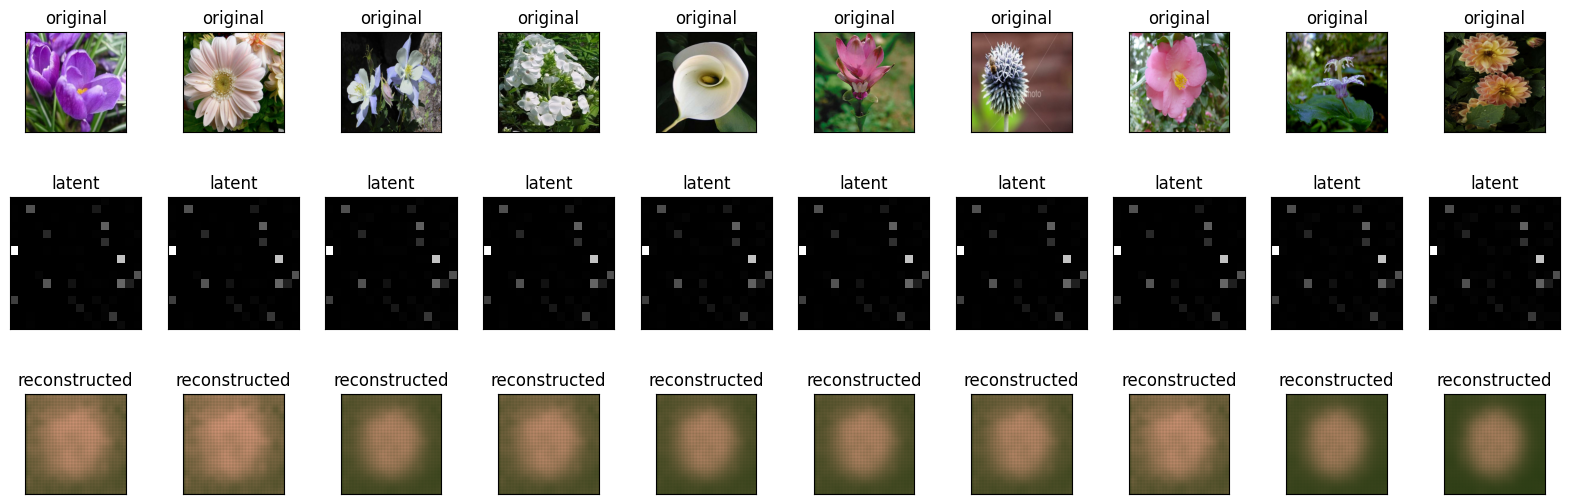

In [ ]:
# Visualizzazione di 10 immagini
i = 1
show_results(test_data[i:i+10], encoded_imgs[i:i+10], decoded_imgs[i:i+10])

Salvataggio dei pesi

In [ ]:
checkpoint_path = os.getcwd() + "/drive/MyDrive/Colab Notebooks/training/cp-variante1.weights.h5"

autoencoder2.save_weights(checkpoint_path)

Valutazione della ricostuzione

In [ ]:
ssim_mean, ssim_variance = evaluate(test_data, decoded_imgs)

print("SSIM medio: ", ssim_mean.numpy())
print("SSIM varianza: ", ssim_variance.numpy())

SSIM medio:  0.29942542
SSIM varianza:  0.011566831




---



---



**VARIANTE 2**

In [ ]:
class Autoencoder3(keras.models.Model):
  def __init__(self, latent_shape):
    super(Autoencoder3, self).__init__()

    self.latent_dim = latent_shape[0]*latent_shape[1] # numero di unità del livello completamente connesso (pixel dell'immagine compressa)

    self.encoder = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3,3), strides=2, padding='same', activation='relu', kernel_initializer=keras.initializers.HeNormal()),    #(128x128)x32
            tf.keras.layers.BatchNormalization(),                                                                                                 #(128x128)x32
            tf.keras.layers.Conv2D(64, (3,3), strides=2, padding='same', activation='relu', kernel_initializer=keras.initializers.HeNormal()),    #(64x64)x64
            tf.keras.layers.BatchNormalization(),                                                                                                 #(64x64)x64
            tf.keras.layers.Conv2D(128, (3,3), strides=2, padding='same', activation='relu', kernel_initializer=keras.initializers.HeNormal()),   #(32x32)x128
            tf.keras.layers.BatchNormalization(),                                                                                                 #(32x32)x128
            tf.keras.layers.Conv2D(256, (3,3), strides=2, padding='same', activation='relu', kernel_initializer=keras.initializers.HeNormal()),   #(16x16)x256
            tf.keras.layers.BatchNormalization(),                                                                                                 #(16x16)x256
            tf.keras.layers.Flatten(),                                                                                                            #(16x16x256)x1
            tf.keras.layers.Dense(self.latent_dim, activation='relu', kernel_initializer=keras.initializers.HeNormal())
        ])

    self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(16*16*256, activation='relu', input_shape=(self.latent_dim,), kernel_initializer=keras.initializers.HeNormal()),#(16x16x256)x1
            tf.keras.layers.Reshape((16,16,256)),                                                                                                 #(16x16)x256
            tf.keras.layers.Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu'),                                            #(32x32)x128
            tf.keras.layers.BatchNormalization(),                                                                                                 #(32x32)x128
            tf.keras.layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu'),                                             #(64x64)x64
            tf.keras.layers.BatchNormalization(),                                                                                                 #(64x64)x64
            tf.keras.layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu'),                                             #(128x128)x32
            tf.keras.layers.BatchNormalization(),                                                                                                 #(128x128)x32
            tf.keras.layers.Conv2DTranspose(3, (3,3), strides=2, padding='same', activation='sigmoid')                                            #(256x256)x3
    ])

  def call(self, x):
    encoded = self.encoder(x) # x: dimensione dello spazio latente
    decoded = self.decoder(encoded) # decoded: immagine ricostruita
    return decoded

Addestramento

In [ ]:
latent_shape = (32, 32) # dimensione dello spazio latente
autoencoder3 = Autoencoder3(latent_shape) # istaziazione del modello

autoencoder3.compile(optimizer='adam', loss='mean_absolute_error') # configurazione per l'addestramento del modello

autoencoder3.fit(training_set, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_set, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1065s 15s/step - loss: 0.2316 - val_loss: 0.1689
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1042s 15s/step - loss: 0.1618 - val_loss: 0.1387
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1024s 15s/step - loss: 0.1367 - val_loss: 0.1274
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1018s 15s/step - loss: 0.1246 - val_loss: 0.1178
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1050s 15s/step - loss: 0.1181 - val_loss: 0.1132
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1024s 15s/step - loss: 0.1125 - val_loss: 0.1130
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1018s 15s/step - loss: 0.1081 - val_loss: 0.1031
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1028s 15s/step - loss: 0.1030 - val_loss: 0.1003
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1027s 15s/step - loss: 0.0978 - val_loss: 0.0951
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1026s 15s/step - loss: 0.0938 - val_loss: 0.0909


Inferenza

In [ ]:
# Generazione delle immagini compresse
encoded_imgs = autoencoder3.encoder.predict(test_data)

# Ricostruzione delle immagini
decoded_imgs = autoencoder3.decoder.predict(encoded_imgs)

26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 652ms/step


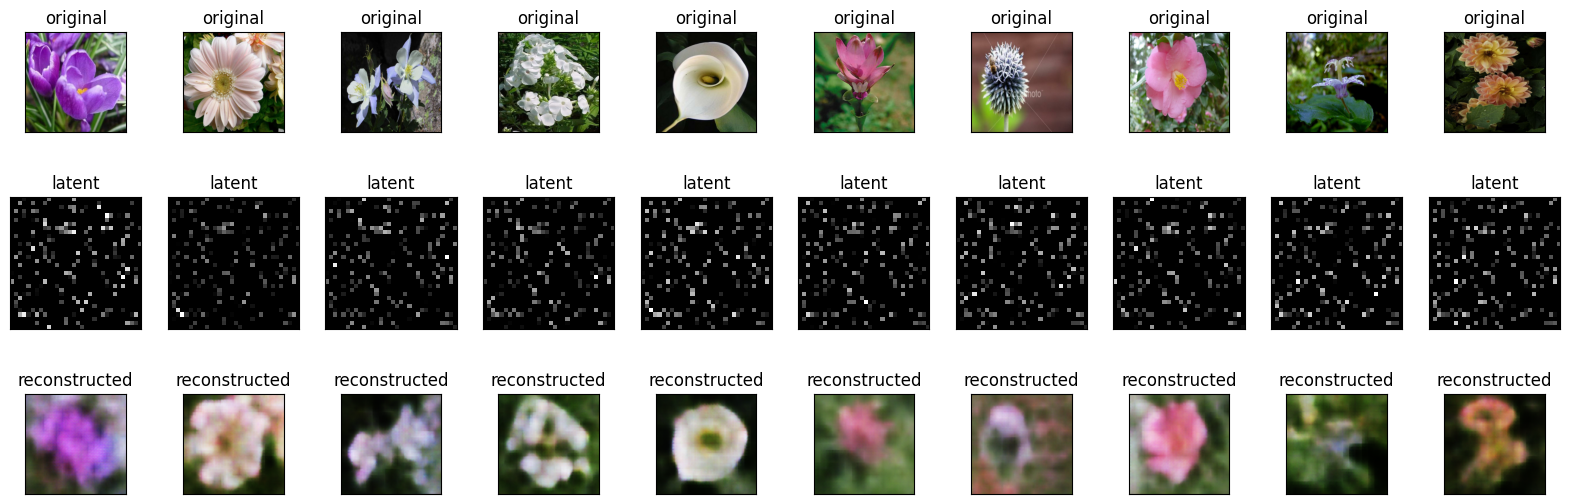

In [ ]:
# Visualizzazione di 10 immagini
i = 1
show_results(test_data[i:i+10], encoded_imgs[i:i+10], decoded_imgs[i:i+10])

Salvataggio dei pesi

In [ ]:
checkpoint_path = os.getcwd() + "/drive/MyDrive/Colab Notebooks/training/cp-variante2.weights.h5"

autoencoder3.save_weights(checkpoint_path)

Valutazione delle prestazioni

In [ ]:
ssim_mean, ssim_variance = evaluate(test_data, decoded_imgs)

print("SSIM medio: ", ssim_mean.numpy())
print("SSIM varianza: ", ssim_variance.numpy())

SSIM medio:  0.4189291
SSIM varianza:  0.0156003665




---


---





---
***ULTERIORI VARIANTI***



***parametro modificato: funzione di perdita (mae -> mse)***

In [ ]:
latent_shape = (32, 32) # dimensione dello spazio latente
autoencoder3 = Autoencoder3(latent_shape) # istaziazione del modello

autoencoder3.compile(optimizer='adam', loss='mse') # configurazione per l'addestramento del modello

autoencoder3.fit(training_set, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_set, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1058s 15s/step - loss: 0.0761 - val_loss: 0.0455
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1004s 15s/step - loss: 0.0424 - val_loss: 0.0320
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1059s 15s/step - loss: 0.0311 - val_loss: 0.0265
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1011s 15s/step - loss: 0.0261 - val_loss: 0.0227
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1005s 15s/step - loss: 0.0228 - val_loss: 0.0224
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 999s 15s/step - loss: 0.0214 - val_loss: 0.0203
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1013s 15s/step - loss: 0.0198 - val_loss: 0.0190
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 997s 15s/step - loss: 0.0187 - val_loss: 0.0168
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 984s 15s/step - loss: 0.0169 - val_loss: 0.0157
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 982s 15s/step - loss: 0.0155 - val_loss: 0.0150


In [ ]:
# Generazione delle immagini compresse
encoded_imgs = autoencoder3.encoder.predict(test_data)

# Ricostruzione delle immagini
decoded_imgs = autoencoder3.decoder.predict(encoded_imgs)

26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 739ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 667ms/step


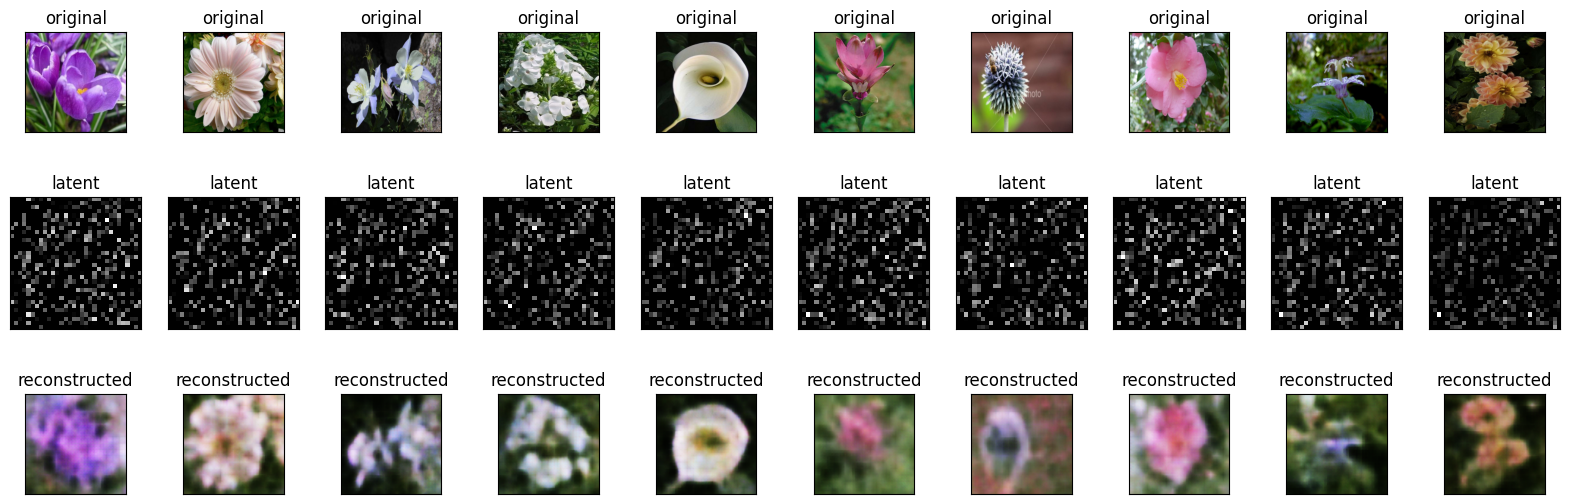

In [ ]:
# Visualizzazione di 10 immagini
i = 1
show_results(test_data[i:i+10], encoded_imgs[i:i+10], decoded_imgs[i:i+10])

In [ ]:
ssim_mean, ssim_variance = evaluate(test_data, decoded_imgs)

print("SSIM medio: ", ssim_mean.numpy())
print("SSIM varianza: ", ssim_variance.numpy())

SSIM medio:  0.4213872
SSIM varianza:  0.015000714




---



---



***paramentro modificato: numero di epoche(10 -> 20)***

In [ ]:
latent_shape = (32, 32) # dimensione dello spazio latente
autoencoder = Autoencoder(latent_shape) # istaziazione del modello

autoencoder.compile(optimizer='adam', loss='mae') # configurazione per l'addestramento del modello

autoencoder.fit(training_set, batch_size=BATCH_SIZE, epochs=20, validation_data=val_set, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - loss: 0.3068 - val_loss: 0.1836
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - loss: 0.1727 - val_loss: 0.1507
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - loss: 0.1470 - val_loss: 0.1356
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - loss: 0.1334 - val_loss: 0.1243
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - loss: 0.1225 - val_loss: 0.1179
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - loss: 0.1154 - val_loss: 0.1121
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - loss: 0.1110 - val_loss: 0.1096
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - loss: 0.1079 - val_loss: 0.1033
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - loss: 0.1042 - val_loss: 0.1025
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - loss: 0.1020 - val_loss: 0.0998
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - loss: 0.1003 - val_loss: 0.0985
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - loss: 0.0

In [ ]:
# Generazione delle immagini compresse
encoded_imgs = autoencoder.encoder.predict(test_data)

# Ricostruzione delle immagini
decoded_imgs = autoencoder.decoder.predict(encoded_imgs)

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step


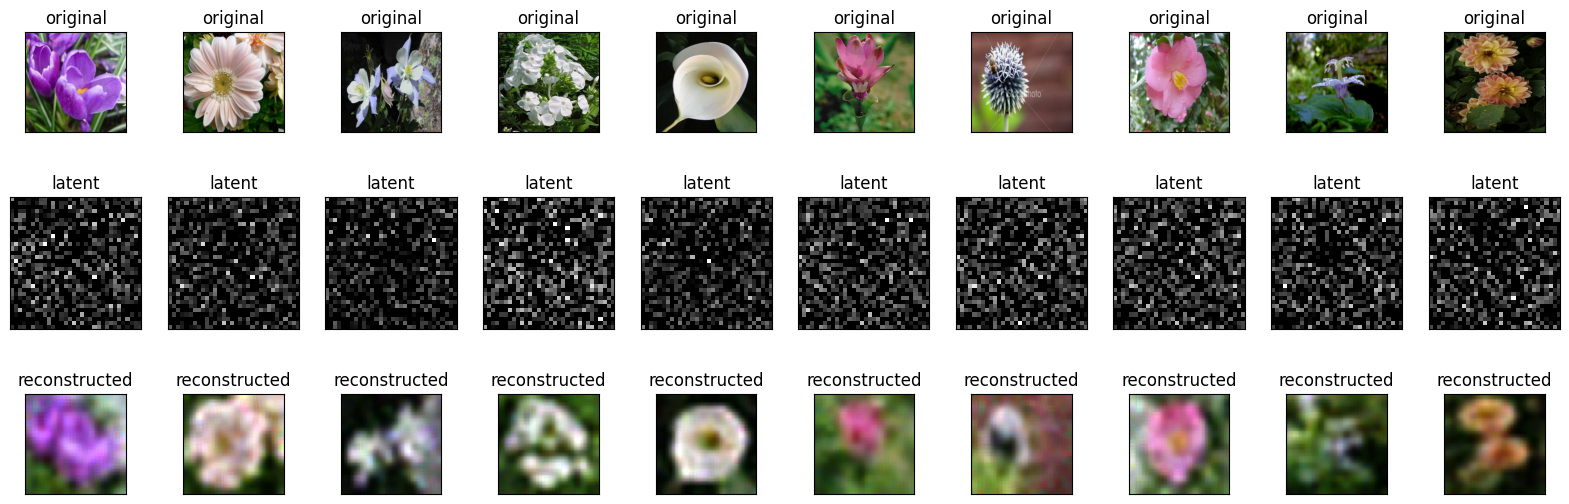

In [ ]:
# Visualizzazione di 10 immagini
i = 1
show_results(test_data[i:i+10], encoded_imgs[i:i+10], decoded_imgs[i:i+10])

In [ ]:
ssim_mean, ssim_variance = evaluate(test_data, decoded_imgs)

print("SSIM medio: ", ssim_mean.numpy())
print("SSIM varianza: ", ssim_variance.numpy())

SSIM medio:  0.41337436
SSIM varianza:  0.015442828




---



---

